In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, RepeatVector

In [2]:
date = pd.to_datetime('2009-12-31')
t = yf.Ticker('AAPL')
df_aapl = t.history(start=date)

In [3]:
df_aapl.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-12-31 00:00:00-05:00,6.444133,6.450785,6.366427,6.371567,352410800,0.0,0.0
2010-01-04 00:00:00-05:00,6.453204,6.485556,6.421457,6.470741,493729600,0.0,0.0
2010-01-05 00:00:00-05:00,6.488580,6.518514,6.447762,6.481928,601904800,0.0,0.0
2010-01-06 00:00:00-05:00,6.481929,6.507629,6.372173,6.378825,552160000,0.0,0.0
2010-01-07 00:00:00-05:00,6.402408,6.409967,6.320772,6.367032,477131200,0.0,0.0


In [4]:
def window_and_reshape(data, timestep):
    NUM_FEATURES = 1
    samples = int(data.shape[0] / timestep)
    result = np.array(np.array_split(data, samples))
    return result.reshape((samples, timestep, NUM_FEATURES))

def transform(train, test, timestep=5):
    train_remainder = train.shape[0] % timestep
    test_remainder = test.shape[0] % timestep
    if train_remainder != 0 and test_remainder != 0:
        train = train[train_remainder : ]
        test = test[test_remainder : ]
    elif train_remainder != 0:
        train = train[train_remainder : ]
    elif test_remainder != 0:
        test = test[test_remainder : ]
    return window_and_reshape(train, timestep), window_and_reshape(test, timestep)

def split_data(data, date_seperator='2019-12-30'):
    train = data[data.index <= date_seperator]
    test = data[data.index > date_seperator]
    return train, test

In [5]:
train_data, test_data = split_data(df_aapl)

In [6]:
train_trans, test_trans = transform(train_data['Close'], test_data['Close'])

In [7]:
train_trans.shape

(503, 5, 1)

In [8]:
test_trans.shape

(215, 5, 1)

In [9]:
def to_supervised(train, n_input=5, n_out=5):
    """
    Converts our time series prediction problem to a
    supervised learning problem.
    """
    # flatted the data
    data =  train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = [], []
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
            # move along one time step
            in_start += 1
    return np.array(X), np.array(y)

In [10]:
X_train, y_train = to_supervised(train_trans)

In [11]:
X_train.shape

(2506, 5, 1)

In [12]:
y_train.shape

(2506, 5)

In [13]:
def build_model(train, n_input=5):
    """
    Compiles and fits an LSTM model.
    """
    # prepare the data
    X_train, y_train = to_supervised(train)
    # define params
    VERBOSE, NUM_EPOCHS, BATCH_SIZE = 0, 3, 30 # if you want to see it train, set VERBOSE=1
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1] 
    # define model
    model = Sequential() 
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    # compile the model
    print('compiling model....')
    model.compile(optimizer='adam', loss='mse')
    print("fitting model....")
    # fit the model
    model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print('model is fit....')
    return model

In [14]:
model = build_model(train_trans)


compiling model....

fitting model....

model is fit....


In [15]:
def forecast(model, history, n_input=5):
    """
    Given last weeks actual data, forecasts next weeks prices.
    """
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

def get_predictions(train, test, model, n_input) -> np.array:
    """
    compiles models predictions week by week over entire
    test set.
    """
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = []
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    return np.array(predictions)

In [16]:
pred = get_predictions(train_trans, test_trans, model, 5)

In [17]:
pred

array([[ 70.37154 ,  70.295166,  70.69682 ,  70.31434 ,  69.97943 ],
       [ 73.64184 ,  73.478905,  73.87229 ,  73.475464,  73.17944 ],
       [ 76.40328 ,  76.18708 ,  76.722855,  76.28197 ,  75.89618 ],
       ...,
       [171.30096 , 169.35684 , 172.14883 , 170.57822 , 168.09    ],
       [172.90347 , 170.77188 , 173.16382 , 171.80775 , 169.86282 ],
       [170.20337 , 168.13979 , 170.64038 , 169.2023  , 167.13345 ]],
      dtype=float32)

In [18]:
def plot_results(test, preds, df, ylabel='AAPL stock Price') -> None:
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index # df can be the pd.Series of closing prices
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  ax.set_xlabel('Date')
  ax.set_ylabel(ylabel)
  ax.legend()
  plt.show()

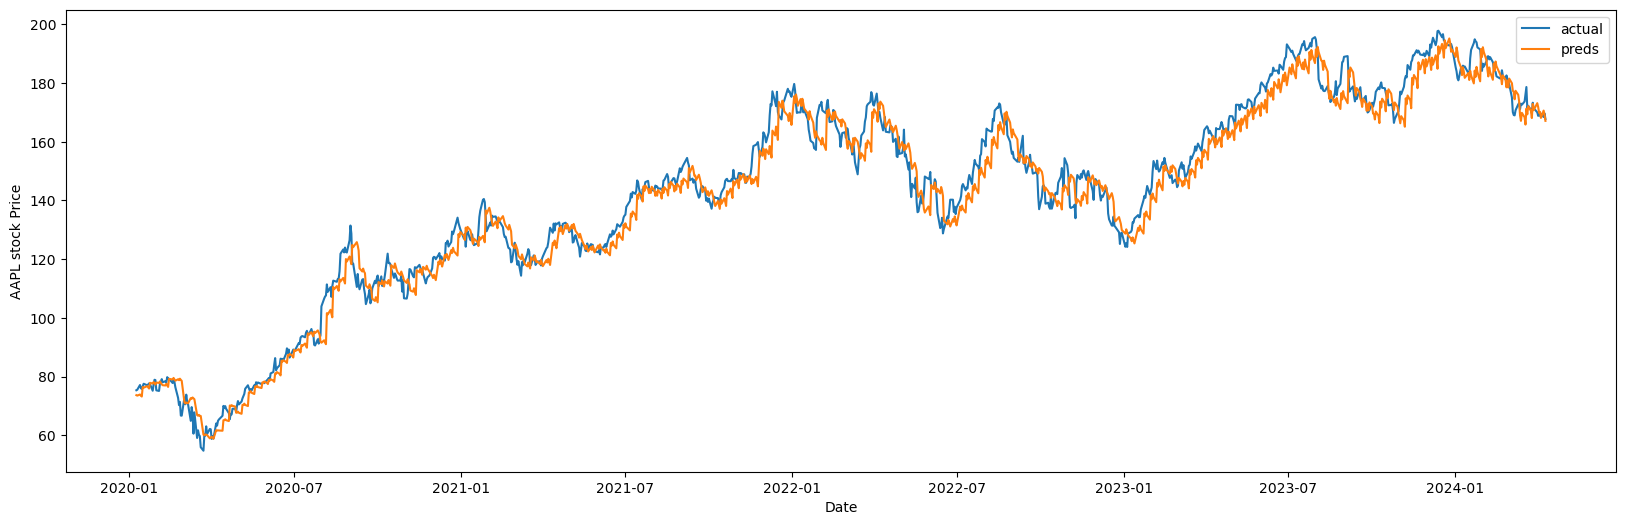

In [19]:
plot_results(test_trans, pred, df_aapl)

In [20]:
test_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-04 00:00:00-04:00,170.289993,171.919998,168.820007,168.820007,53704400,0.0,0.0
2024-04-05 00:00:00-04:00,169.589996,170.389999,168.949997,169.580002,42055200,0.0,0.0
2024-04-08 00:00:00-04:00,169.029999,169.199997,168.240005,168.449997,37425500,0.0,0.0
2024-04-09 00:00:00-04:00,168.699997,170.080002,168.350006,169.669998,42451200,0.0,0.0
2024-04-10 00:00:00-04:00,168.800003,169.089996,167.110001,167.779999,49587200,0.0,0.0


In [21]:
test_trans[-1:]

array([[[168.82000732],
        [169.58000183],
        [168.44999695],
        [169.66999817],
        [167.77999878]]])

In [22]:
test_trans.shape

(215, 5, 1)

In [23]:
dates = pd.DataFrame(df_aapl[-(test_trans.shape[0]*test_trans.shape[1]):].index)
reshaped_test = pd.DataFrame(test_trans.reshape((test_trans.shape[0]*test_trans.shape[1], 1)), columns=['Close'])
reshaped_preds = pd.DataFrame(pred.reshape((test_trans.shape[0]*test_trans.shape[1], 1)), columns=['Close'])
test_data_with_dates = pd.concat([dates, reshaped_test], axis=1)
pred_data_with_dates = pd.concat([dates, reshaped_preds], axis=1)

In [24]:
## Creating bollinger bands using dataframe
def bollinger_bands(df, n, m):
    data = df['Close']
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std()
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)    
    return df

## adding buy and sell signal
def add_signal(df):
    buy_list = []
    sell_list = []
    for i in range(len(df.index)):
        if (df['Close'][i] > df['BU'][i]):           # sell signal     daily
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [25]:
df = bollinger_bands(pred_data_with_dates, 20, 2)
dfa = add_signal(df)

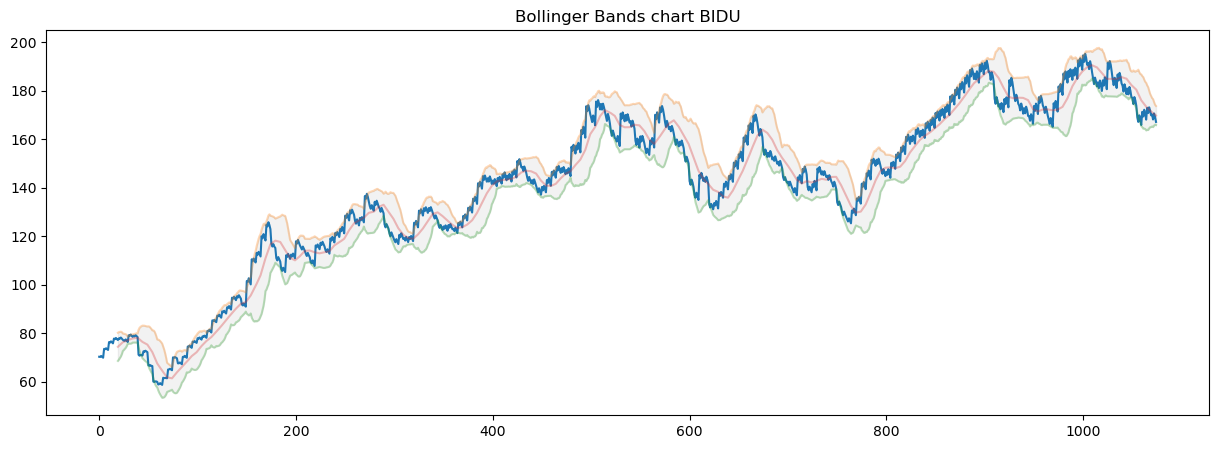

In [26]:
# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
# plt.title('Bollinger Bands chart ' + str(ticker))
plt.title('Bollinger Bands chart ' + 'BIDU')
plt.plot(df.index, df['Close'])
plt.plot(df.index, df['BU'], alpha=0.3)
plt.plot(df.index, df['BL'], alpha=0.3)
plt.plot(df.index, df['B_MA'], alpha=0.3)
plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)

plt.show()

In [27]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df.index, df['Close'])
    plt.title('Price chart (Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df.index, df['Close'], label='Close')

    plt.plot(df.index, df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df.index, df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df.index, df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df.index, df['Buy'], label='Buy', marker='^')
    plt.scatter(df.index, df['Sell'], label='Sell', marker='v')

    plt.legend()

    plt.show()

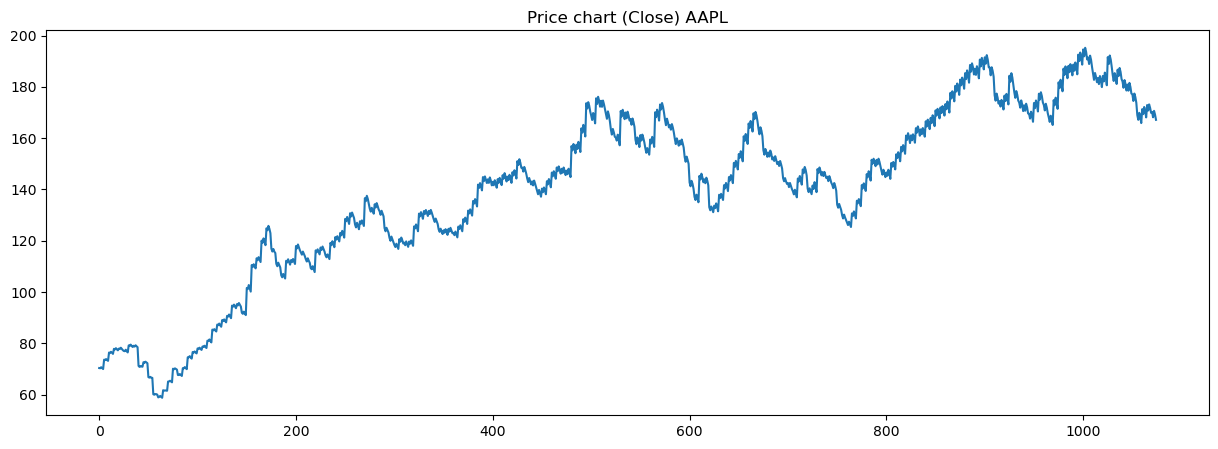

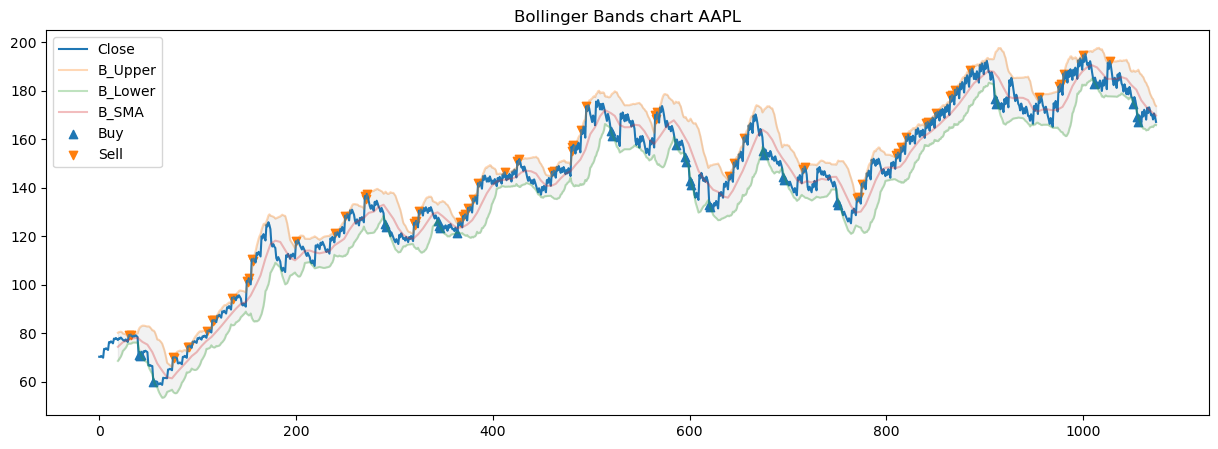

In [28]:
plot_signals(dfa, 'AAPL')

In [29]:
def get_profit(df, investment):
    n_of_buys = 0
    n_of_sells = 0
    stocks = 0
    stock_balance = 0;
    invested = 0
    sold = 0
    dates = []
    
    for i in range(len(df['Close'])):
        if (df['Buy'][i] > 0):
            n_of_buys += 1
            dates.append(df['Date'][i])
        if (df['Sell'][i] > 0):
            n_of_sells +=1
            dates.append(df['Date'][i])

    for i in range(len(df['Close'])):
        if (df['Buy'][i] > 0):
            stocks += investment/df['Buy'][i]
            invested += investment
            stock_balance += investment/df['Buy'][i]
        if (df['Sell'][i] > 0) and stock_balance > 0:
            sold += (stocks/n_of_sells) * df['Sell'][i]
            stock_balance -= stocks/n_of_sells
    min_date = np.min(dates)
    max_date = np.max(dates)
    duration = max_date - min_date
    profit = sold - invested + stock_balance * df['Close'].iloc[-1]
    profit_percent = profit * 100 / invested
    total_investment = investment * n_of_buys
    print('Duration: ', duration, ':', min_date, '-', max_date)
    print('Total investment: ', total_investment)
    print('Profit: ', profit)
    print('Profit percent: ', profit_percent)


In [30]:
profit = get_profit(dfa, 1000)

Duration:  1489 days 23:00:00 : 2020-02-14 00:00:00-05:00 - 2024-03-14 00:00:00-04:00
Total investment:  31000
Profit:  7999.016746076522
Profit percent:  25.8032798260533
